In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from scipy.fftpack import fft,fftfreq
from matplotlib import cm
import networkx as nx
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
import ndlib.models.dynamic as dm
from ndlib.utils import multi_runs
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments.NodeStochastic as ns

### Problem1. Five hallmarks in an SIR discrete event model using Gillespie’s direct algorithm

Stochastic SIR without Demography

In [2]:
def SIR_using_Gillespies_without_demo(INP, beta, gamma, t_stop):
    S, I, R, t = [], [], [], []
    S.append(INP[0]), I.append(INP[1]), R.append(INP[2])
    t.append(0)

    while t[-1] < t_stop:
        N = S[-1]+I[-1] + R[-1]
        Rate1 = beta * S[-1] * I[-1]/N
        Rate2 = gamma * I[-1]

        Rate_total = Rate1 + Rate2         
        if Rate_total == 0:
            break

        random1,random2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
        t_step = -math.log(random1) / Rate_total
        t.append(t[-1]+t_step)

        if random2 < Rate1: # Event 1: infection
            S.append(S[-1]-1)
            I.append(I[-1]+1)
            R.append(R[-1])
        else: # Event 2: recovery
            S.append(S[-1])
            I.append(I[-1]-1)
            R.append(R[-1]+1)

    return [t, S, I, R]

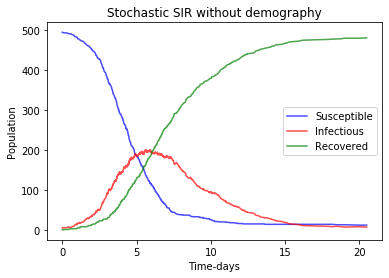

In [3]:
X0 = 495
Y0 = 5
Z0 = 0

INPUT = np.array((X0,Y0,Z0))

beta = 1.4
gamma = 0.3
t_stop = 20

results = SIR_using_Gillespies_without_demo(INPUT, beta, gamma, t_stop)

plt.plot(results[0], results[1], c="b", alpha=0.7, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.7, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.7, label="Recovered")
plt.legend()
plt.xlabel("Time-days")
plt.ylabel("Population")
plt.title("Stochastic SIR without demography")
plt.show()

Stochastic SIR with demography

In [4]:
def SIR_using_Gillespies_with_demo(INP, beta, gamma, mu, epsilon, t_stop):
    S, I, R, t = [], [], [], []
    S.append(INP[0]), I.append(INP[1]), R.append(INP[2])
    t.append(0)
    
    while t[-1] < t_stop:
        N = S[-1] + I[-1] + R[-1]

        Rate1 = beta * S[-1] * I[-1] / N #infection
        Rate2 = gamma * I[-1] #recovery
        Rate3 = mu * N #birth
        Rate4 = mu * S[-1] #death susceptible
        Rate5 = mu * I[-1] #death infected
        Rate6 = mu * R[-1] #death recovered
        Rate7 = epsilon #imports
        Rate_total = Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6 + Rate7
        
        if Rate_total == 0:
            break
        
        random1,random2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
        t_step = -math.log(random1) / Rate_total
        t.append(t[-1] + t_step)

        if random2 < Rate1:                     
            # Event 1: Infection
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            S[-1] -= 1
            I[-1] += 1
        elif random2 < (Rate1 + Rate2):   
            # Event 2: Recovery
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            I[-1] -= 1
            R[-1] += 1
        elif random2 < (Rate1 + Rate2 + Rate3):
            # Event 3: Birth   
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])        
            S[-1] += 1
        elif random2 < (Rate1 + Rate2 + Rate3 + Rate4):  
            # Event 4: Death S   
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            S[-1] -= 1
        elif random2 < (Rate1 +Rate2 + Rate3 + Rate4 + Rate5):  
            # Event 5: Death I 
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            I[-1] -= 1
        elif random2 < (Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6): 
            # Event 6: Death R  
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            R[-1] -= 1
        else:
            # Event 7: Imports
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            I[-1] += 1
            
    return [t, S, I, R]

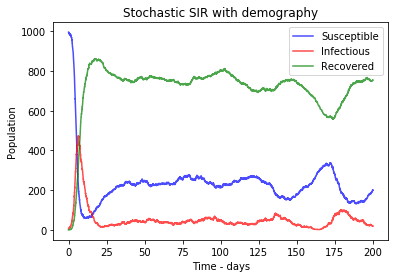

In [5]:
X0 = 995
Y0 = 5
Z0 = 0

INPUT = np.array((X0,Y0,Z0))

beta = 1.4
gamma = 0.3
mu = 1/60
epsilon = 0
t_stop = 200

results = SIR_using_Gillespies_with_demo(INPUT, beta, gamma, mu, epsilon, t_stop)

plt.plot(results[0], results[1], c="b", alpha=0.7, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.7, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.7, label="Recovered")
plt.legend()
plt.xlabel("Time - days")
plt.ylabel("Population")
plt.title("Stochastic SIR with demography")
plt.show()

### 1. Variability

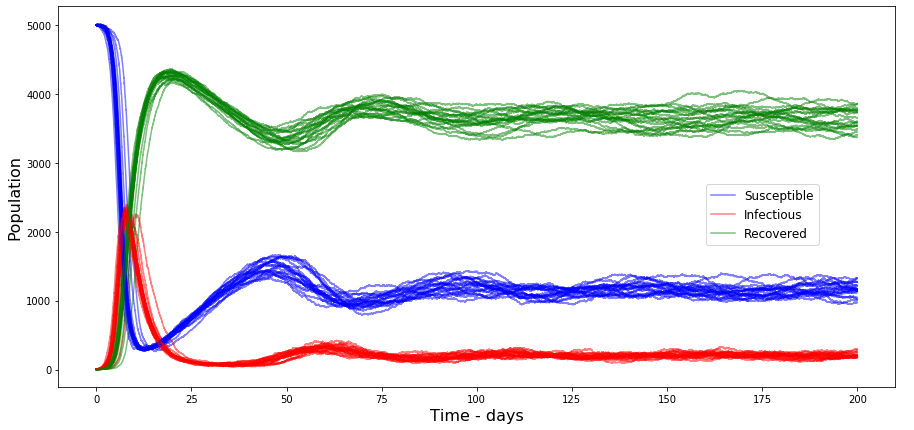

In [6]:
X0 = 4995
Y0 = 5
Z0 = 0

beta = 1.4
gamma = 0.3
mu = 1/60
epsilon = 0
t_stop = 200

INPUT = np.array((X0,Y0,Z0))

fig,ax = plt.subplots(figsize=(15,7))

for i in range(20):
    result = SIR_using_Gillespies_with_demo(INPUT, beta, gamma, mu, epsilon, t_stop)
    ax.plot(result[0], result[1] , c="b", alpha=0.5, label="Susceptible")
    ax.plot(result[0], result[2] , c="r", alpha=0.5, label="Infectious")
    ax.plot(result[0], result[3] , c="g", alpha=0.5, label="Recovered")
    
ax.set_xlabel('Time - days', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
fig.legend(labels=['Susceptible','Infectious','Recovered'],loc="right", borderaxespad=8, fontsize=12)
plt.show()

In [7]:
#deterministic SIR
def SIR_dem(y, t, beta, gamma, mu):
    S, I, R= y
    N = S + I + R
    
    dSdt = mu*N - beta*I* S/N - mu*S
    dIdt = beta*I * S/N - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    
    return [dSdt, dIdt, dRdt]

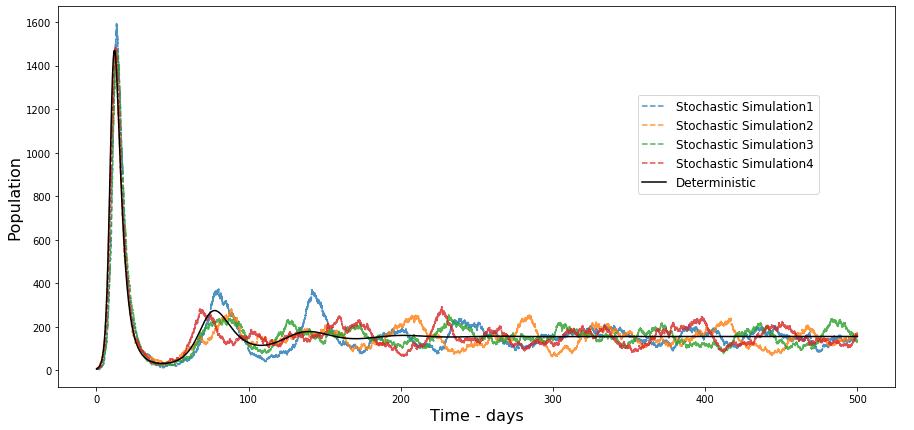

In [8]:
beta = 1
gamma = 1/3
mu = 1/60
epsilon = 0.001

t = np.linspace(0,500,1000)
t_stop = 500

fig,ax = plt.subplots(figsize=(15,7))

res1 = [0,0,0]

res1 = odeint(SIR_dem, INPUT, t, args=(beta, gamma, mu))

for i in range(4):
    res2 = SIR_using_Gillespies_with_demo(INPUT, beta, gamma, mu, epsilon, t_stop)
    ax.plot(res2[0], res2[2] , linestyle='--', alpha=0.8, label="Infectious")

ax.plot(t, res1[:,1], alpha=1, color='black', lw = 1.5)
ax.set_xlabel('Time - days', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
fig.legend(labels=['Stochastic Simulation1','Stochastic Simulation2','Stochastic Simulation3','Stochastic Simulation4', 'Deterministic'],loc="upper right", borderaxespad=8, fontsize=12)
plt.show()

### 2. Variance and covariance

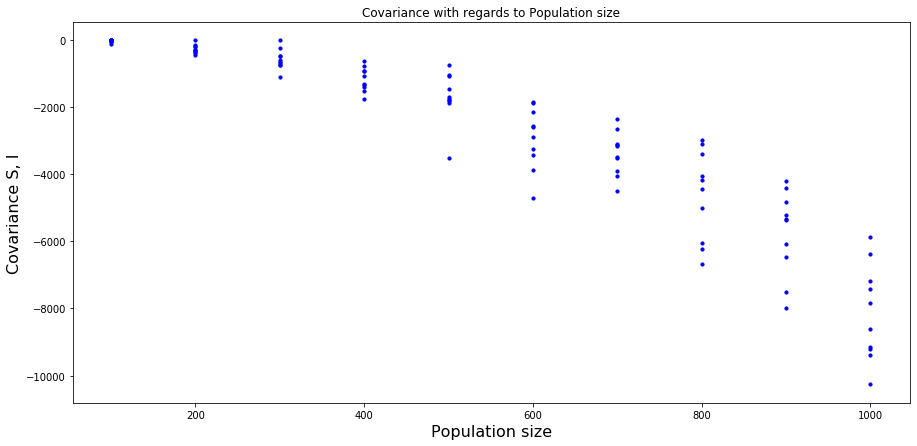

In [9]:
def covariance(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov


def cov_per_run(N0):
    cov = []
    for i in range(10): 
        Y0 = 4
        X0 = N0-Y0
        Z0 = N0-Y0-X0

        INP = np.array((X0,Y0,Z0))

        SIR_without_demo = SIR_using_Gillespies_without_demo(INP, beta, gamma, t_stop)

        cov.append(covariance(SIR_without_demo[1], SIR_without_demo[2]))
    return cov

def cov_for_diff_pop_size():
    population_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    covariances = []
    for i in population_sizes:
        covariances.append(cov_per_run(i))
    return covariances

all_covariances = cov_for_diff_pop_size()   
population_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  

fig,ax = plt.subplots(figsize=(15,7))

for pop_size, cov in zip(population_sizes, all_covariances):
    ax.scatter([pop_size] * len(cov), cov, color = 'b', s = 10)

ax.set_xlabel("Population size", fontsize=16)
ax.set_ylabel("Covariance S, I", fontsize=16)
ax.set_title("Covariance with regards to Population size")
# plt.legend()
plt.show()

# print(all_covariances)

### 3. Increased Transients

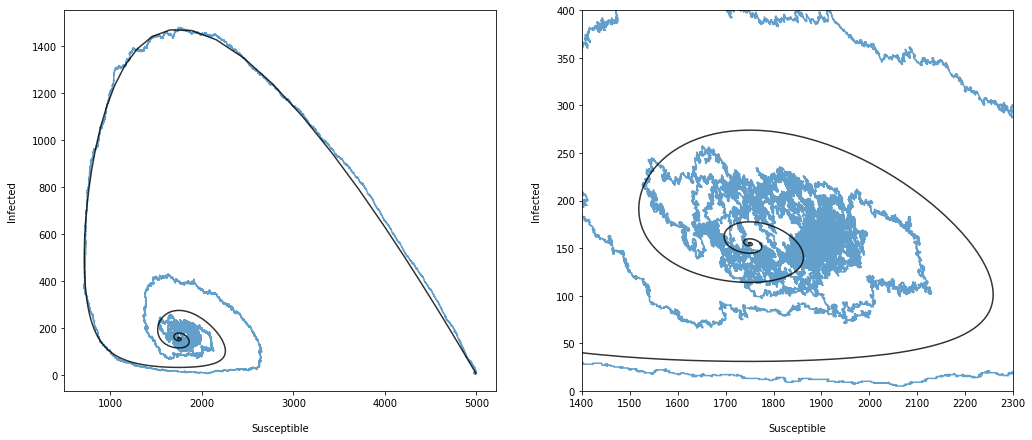

In [10]:
res1 = odeint(SIR_dem, INPUT, t, args=(beta, gamma, mu))
res2 = SIR_using_Gillespies_with_demo(INPUT, beta, gamma, mu, epsilon, t_stop)

f, (sub1, sub2) = plt.subplots(1, 2, figsize=(17,7)) 

sub1.plot(res2[1], res2[2], alpha=0.7, label="Infectious")
sub1.plot(res1[:,0], res1[:,1], alpha=0.8, color='black')
sub1.set_xlabel('Susceptible', labelpad = 15)
sub1.set_ylabel('Infected', labelpad = 15)

sub2.plot(res2[1],res2[2], alpha=0.7, label="Infectious")
sub2.plot(res1[:,0], res1[:,1], alpha=0.8, color='black')
sub2.set_xlim(1400, 2300)
sub2.set_ylim(0, 400)
sub2.set_xlabel('Susceptible', labelpad = 15)
sub2.set_ylabel('Infected', labelpad = 15)

plt.show()

### 4. Stochastic Resonance

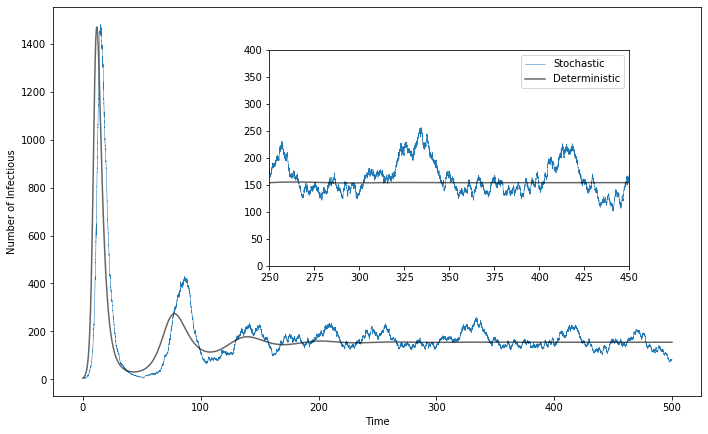

In [11]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax1.plot(res2[0], res2[2], label="Stochastic",linewidth=0.5)
ax1.plot(t, res1[:,1], color='black', alpha=0.6, label='Deterministic')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Infectious')

ax2=fig.add_axes([0.4, 0.4, 0.5, 0.5])
ax2.plot(res2[0], res2[2], label="Stochastic",linewidth=0.5)
ax2.plot(t, res1[:,1], color='black', alpha=0.6, label='Deterministic')
ax2.set_xlim(250,450)
ax2.set_ylim(0,400)
ax2.legend(loc='best')
plt.show()

### 5. Extinction

In [12]:
N0_list = np.arange(1000,100000,1000)

beta = 0.8
gamma = 2/3
mu = 0.000055 #1/60
# epsilon = 0
t_stop = 200

In [13]:
#runs for ~ 9 minutes
number_of_extinctions = []
number_of_extinctions_avg = []

first_extinction_time_list = []
first_passage_time_list_N = []

for i in N0_list:
    extinction_times = []
    xtimes = 0
    for j in range(10):
        epsilon = 0.02 * math.sqrt(i)
        results = SIR_using_Gillespies_with_demo([(i - 0.05*i), 0.05*i, 0], beta, gamma, mu, epsilon, t_stop)
        for k in range(len(results[2])):
            if results[2][k] <= 0:                
                xtimes += 1
                extinction_times.append(results[0][k])
#                 print(extinction_times)
                break
                
        if xtimes != 0:
            first_extinction_time_list.append(extinction_times[0])
            number_of_extinctions.append(xtimes)
        else:
            first_extinction_time_list.append(0)
            number_of_extinctions.append(0)

    number_of_extinctions_avg.append(np.average(number_of_extinctions))
    first_passage_time_list_N.append(np.average(first_extinction_time_list))

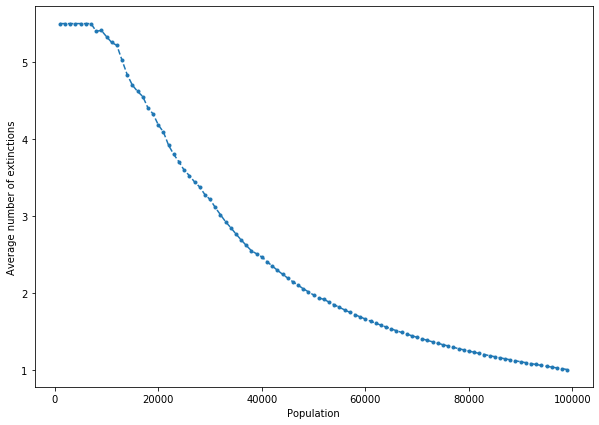

In [14]:
fig, ax = plt.subplots(figsize = [10, 7])
plt.plot(N0_list,number_of_extinctions_avg,'.--')
plt.xlabel('Population')
plt.ylabel('Average number of extinctions')
# plt.savefig('number of extinction2',dpi=500)
plt.show()

First Passage of time

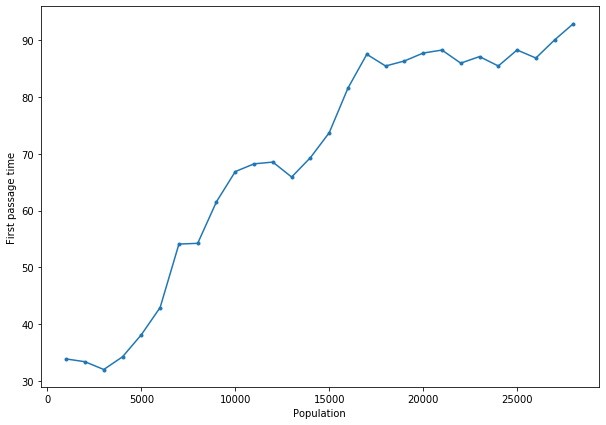

In [15]:
fig, ax = plt.subplots(figsize = [10, 7])
s1 = slice(28)
N0_new = N0_list[s1]

fpt_new = first_passage_time_list_N[s1]

ax.plot(N0_new,fpt_new,'.-')
ax.set_xlabel('Population size')
ax.set_ylabel('First passage time')
# plt.savefig('first passage time2',dpi=500)
plt.show()

## Problem 2. Spatial Models - Metapopulations

In [16]:
def SIR_metapop(INP, beta, gamma, rho, t_stop):
    S, I, R, N, t, rate_i, rate_r, lambdaa = [], [], [], [], [], [], [], []
        
    for i in range(len(INP[0])):
        S.append([INP[0][i]])
        I.append([INP[1][i]])
        R.append([INP[2][i]])
        N.append([INP[0][i] + INP[1][i] + INP[2][i]])
        lambdaa.append(0)
        rate_i.append(0)
        rate_r.append(0)
    t.append(0)
    
    def rates():
        rate_total = 0
        for i in range(len(INP[0])):
            rate_i[i] = lambdaa[i] * S[i][-1] 
            rate_r[i] = gamma * I[i][-1]
            rate_total = rate_total + rate_i[i] + rate_r[i]
        return rate_i, rate_r, rate_total
    
    
    def total_population():
        for i in range(len(INP[0])):
            N[i].append(S[i][-1]+I[i][-1]+R[i][-1])

    def create_lambdaa():
        for i in range(len(INP[0])):
            value = 0
            for j in range(len(INP[0])):
#                 print(type(np.array(I[j][-1])))
#                 print((np.array(I[j][-1])).shape)
#                 print(type(np.array(N[i][-1])))
#                 print((np.array(N[i][-1])).shape)
                value = value + int(beta) * rho[i][j] * np.array(I[j][-1]) / np.array(N[i][-1])
            lambdaa[i] = value

    def events_stay():
        for i in range(len(INP[0])):      
            S[i].append(S[i][-1])
            I[i].append(I[i][-1])
            R[i].append(R[i][-1])
    
    # eventsss
    while t[-1] < t_stop:
        total_population()
#         print(S, I, R)
        
        create_lambdaa()
        rate_i, rate_r, rate_total = rates()

        if rate_total == 0:
            break
        random1, random2 = np.random.uniform(0,1), np.random.uniform(0,1) * rate_total
        t_step = -math.log(random1) / rate_total
        t.append(t[-1] + t_step)

        if random2 < rate_i[0]:
            # Event 1: subpopulation i infection 
            events_stay()
            S[0][-1] -= 1 
            I[0][-1] += 1
        elif random2 < rate_i[0] + rate_i[1]:
            # Event 2: subpopulation j infection         
            events_stay()
            S[1][-1] -= 1 
            I[1][-1] += 1
        elif random2 < rate_i[0] + rate_i[1] + rate_r[0]:
            # Event 3: subpopulation i recovery
            events_stay()
            I[0][-1] -= 1 
            R[0][-1] += 1
        else:
            # Event 4: subpopulation j recovery
            events_stay()
            I[1][-1] -= 1 
            R[1][-1] += 1

    return [t,S,I,R]

Delay-- 4.138130714310924


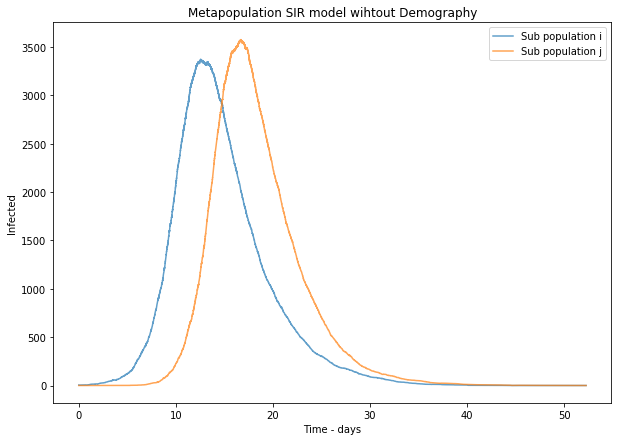

In [17]:
X0 = [9995, 10000]
Y0 = [5, 0]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3
rho = [[1, 0],[0.01, 1]]
t_stop = 50

results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)
peak1_index = results[2][0].index(max(results[2][0]))
peak2_index = results[2][1].index(max(results[2][1]))
delay = results[0][peak2_index] - results[0][peak1_index]
# print(results[2][0][peak1_index])
# print(results[2][1][peak2_index])
height = results[2][0][peak1_index] - results[2][1][peak2_index]
print("Delay--", delay)
# print(height)

fig, ax = plt.subplots(figsize = [10, 7])

plt.plot(results[0], results[2][0], alpha = 0.7, label = "Sub population i")
plt.plot(results[0], results[2][1], alpha = 0.7, label = "Sub population j")
plt.legend()
plt.xlabel("Time - days")
plt.ylabel("Infected")
plt.title("Metapopulation SIR model wihtout Demography")
plt.show()

unidirectional coupling

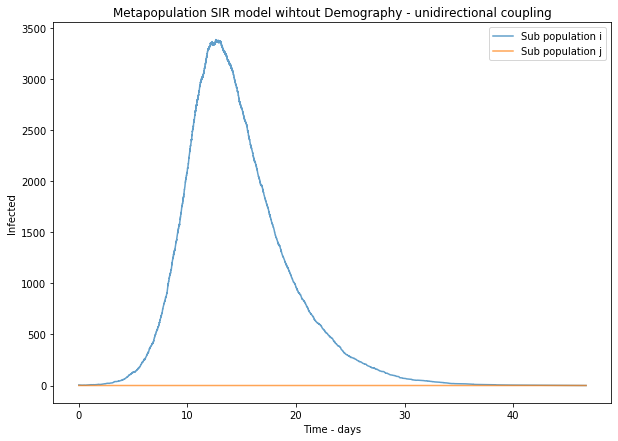

In [18]:
X0 = [9995, 10000]
Y0 = [5, 0]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3
rho = [[1, 0.5],[0, 1]]
t_stop = 50

results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)

fig, ax = plt.subplots(figsize = [10, 7])

plt.plot(results[0], results[2][0], alpha = 0.7, label = "Sub population i")
plt.plot(results[0], results[2][1], alpha = 0.7, label = "Sub population j")
plt.legend()
plt.xlabel("Time - days")
plt.ylabel("Infected")
plt.title("Metapopulation SIR model wihtout Demography - unidirectional coupling")
plt.show()

bidirectional coupling - strong

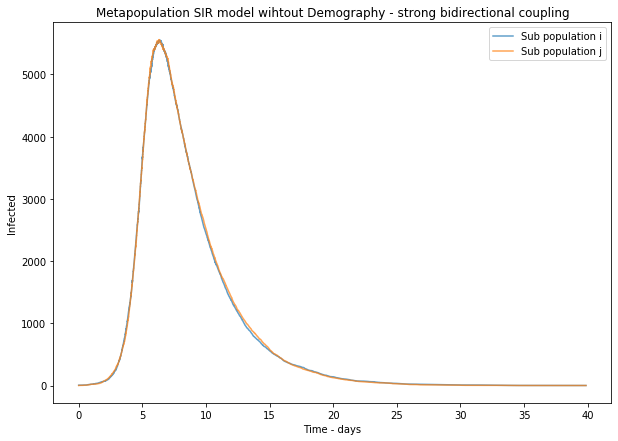

In [19]:
X0 = [9995, 10000]
Y0 = [5, 0]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3
rho = [[1, 0.9],[0.9, 1]]
t_stop = 50

results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)

fig, ax = plt.subplots(figsize = [10, 7])

plt.plot(results[0], results[2][0], alpha = 0.7, label = "Sub population i")
plt.plot(results[0], results[2][1], alpha = 0.7, label = "Sub population j")
plt.legend()
plt.xlabel("Time - days")
plt.ylabel("Infected")
plt.title("Metapopulation SIR model wihtout Demography - strong bidirectional coupling")
plt.show()

bidirectional coupling - weak

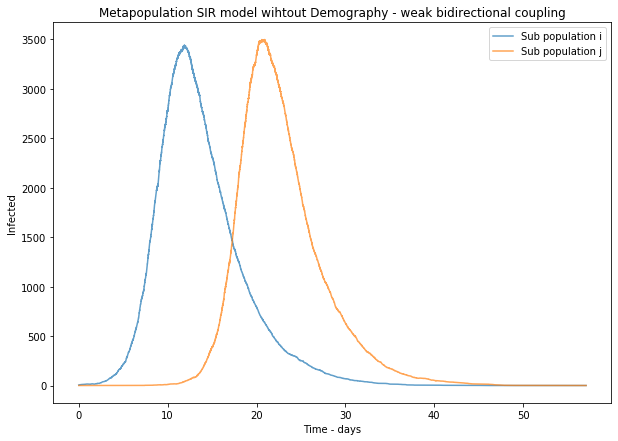

In [20]:
X0 = [9995, 10000]
Y0 = [5, 0]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3
rho = [[1, 0.05],[0.001, 1]]
t_stop = 50

results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)

fig, ax = plt.subplots(figsize = [10, 7])

plt.plot(results[0], results[2][0], alpha = 0.7, label = "Sub population i")
plt.plot(results[0], results[2][1], alpha = 0.7, label = "Sub population j")
plt.legend()
plt.xlabel("Time - days")
plt.ylabel("Infected")
plt.title("Metapopulation SIR model wihtout Demography - weak bidirectional coupling")
plt.show()

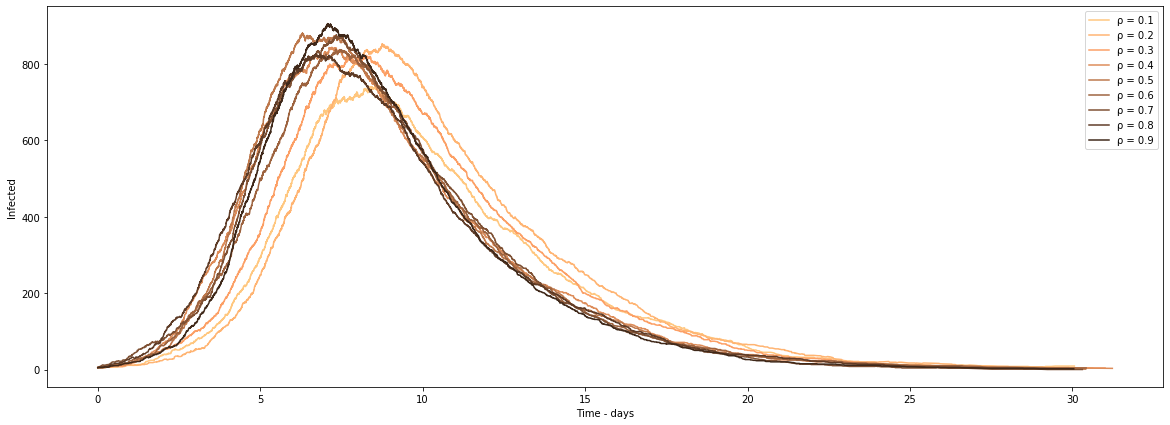

In [21]:
X0 = [1995, 1990]
Y0 = [5, 10]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3

rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0.1, 0.9, 9)
# print(np.average(rho_list))
t_stop = 30

fig, ax = plt.subplots(figsize = [20, 7])

for i in range(len(rho_list)):
    rho[0][1] = rho_list[i]
    results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)
    ax.plot(results[0], results[2][0], alpha = 1, c = cm.copper_r(i/10), label = chr(961) + ' = '+str(round(rho_list[i],2)))
    
ax.legend()
ax.set_xlabel("Time - days")
ax.set_ylabel("Infected")
plt.show()

In [22]:
X0 = [990, 1000]
Y0 = [10, 0]
Z0 = [0, 0]

beta = 1.9
gamma = 0.3

rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0.1, 1, 10)
t_stop = 30

delays = []

for i in range(len(rho_list)):
    rho[1][0] = rho_list[i]
    results = SIR_metapop([X0, Y0, Z0], beta, gamma, rho, t_stop)
    peak1_index = results[2][0].index(max(results[2][0]))
    peak2_index = results[2][1].index(max(results[2][1]))
    delay = results[0][peak2_index] - results[0][peak1_index]
    delays.append(delay)

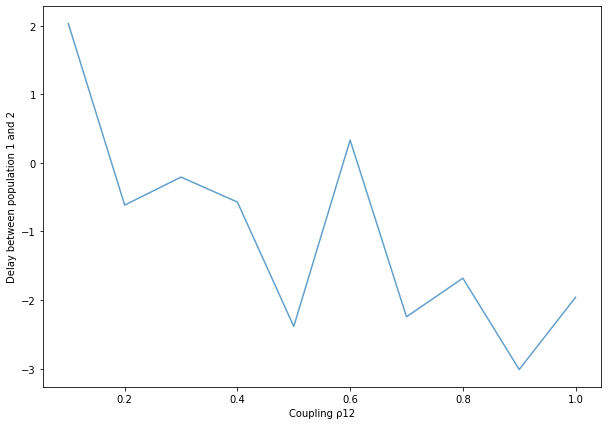

In [23]:
fig, ax = plt.subplots(figsize = [10, 7])

ax.plot(rho_list, delays, alpha = 0.7)
ax.set_xlabel("Coupling " + chr(961) + "12")
ax.set_ylabel("Delay between population 1 and 2")
plt.show()

## Problem 2. Spatial Models - Networks

In [24]:
G_ER = nx.erdos_renyi_graph(100, 0.08, seed=None, directed=False)
print("ER",nx.info(G_ER))

ER Graph with 100 nodes and 397 edges


In [25]:
G_BA = nx.barabasi_albert_graph(100, 8)
print("ER",nx.info(G_BA))

ER Graph with 100 nodes and 736 edges


In [26]:
colors_list = {'S':"gray", 'I':"red", 'R':"green"}

def color(g):   
    color_list = []  
    for node in g:
        color_list.append(colors_list[g.nodes[node]['state']])
    return color_list

In [27]:
def dynamics(g, beta, gamma, t_stop):
    results = []
    results.append(total(g))
    for t in range(0, t_stop):
        update_network(g, beta, gamma)
        results.append(total(g))
    return results

In [28]:
def update_network(g, beta, gamma):
    for node in g: 
        R = np.random.uniform(0,1)
        if g.nodes[node]['state'] == 'S':
            infected_neigh = 0
            for i in g.adj[node]: 
                if g.nodes[i]['state'] == 'I': 
                    infected_neigh += 1

            if R < (1 - (1-beta)**infected_neigh):  # make node infected
                g.nodes[node]['state'] = 'I'

        elif g.nodes[node]['state'] == 'I':  
            if R < gamma:
                g.nodes[node]['state'] = 'R' # make node recovered


def total(g):
    S = 0; I = 0; R = 0
    for node in g:
        if g.nodes[node]['state'] == 'S':
            S += 1
        elif g.nodes[node]['state'] == 'I':
            I += 1
        else:
            R += 1
    return [S, I, R] 

In [29]:
def Netwrok_graph(G, graph, beta, gamma, t_stop):
    results = []
    results.append(total(G))
    fig, ax= plt.subplots()
    for t in np.arange(1, t_stop+1):
#         print(t)
        if(t%5 == 0) or t==1:
            plt.title('Day: ' + str(t), fontsize = 17)
            nx.draw(G, with_labels = False, font_color='white', alpha = 0.6,node_color = color(G), edge_color = 'gray', node_size = 50)
            plt.show()
        update_network(G, beta, gamma)
        results.append(total(G))

    return results

Erdos-Renyi / Random Netwrok

Erdos-Reyni :  Graph with 100 nodes and 253 edges


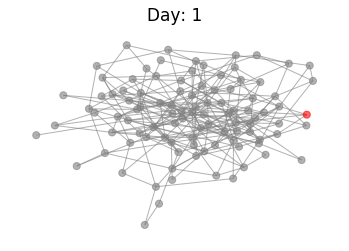

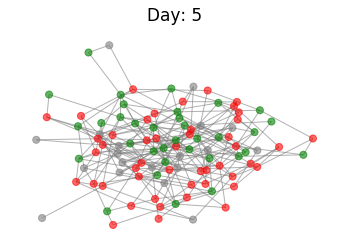

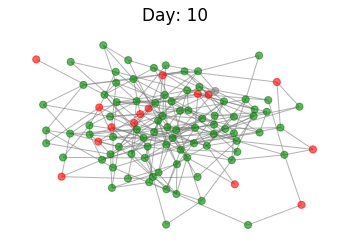

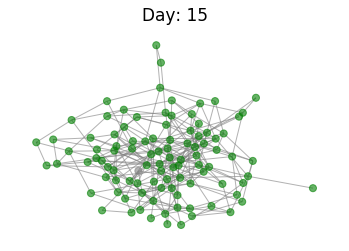

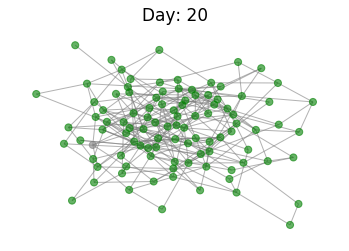

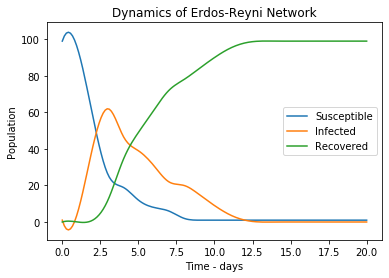

In [30]:
N = 100
beta = 2
gamma = 1/3
t_stop = 20
t_new = np.arange(0, t_stop+1)

graph = 'Erdos-Reyni'
g = nx.erdos_renyi_graph(N, 0.05, seed=7)
print("Erdos-Reyni : ",nx.info(g))

# initially all susceptible
for node in g:   
    g.nodes[node]['state'] = 'S'

random1 = int(np.random.uniform(0,100))

# start infection
g.nodes[random1]['state'] = 'I'

res = Netwrok_graph(g, graph, beta, gamma, t_stop)

count = pd.DataFrame(res,columns=['S', 'I', 'R'])

time = np.linspace(t_new.min(), t_new.max(), 150)

cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,0])
new_results0 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,1])
new_results1 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,2])
new_results2 = cubic_interpolation_model(time)

plt.plot(time, new_results0, label = 'Susceptible')
plt.plot(time, new_results1, label = 'Infected')
plt.plot(time, new_results2, label = 'Recovered')
plt.title('Dynamics of Erdos-Reyni Network')
plt.xlabel('Time - days')
plt.ylabel('Population')
plt.legend(labels=['Susceptible','Infected','Recovered'],loc="right")
plt.show()

Barabasi-Albert / Scale-free network

Barabasi-Albert :  Graph with 100 nodes and 1275 edges


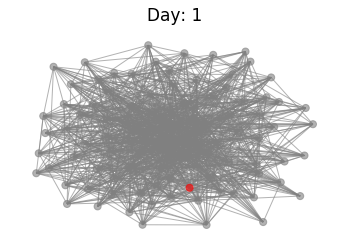

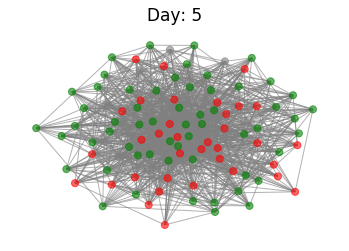

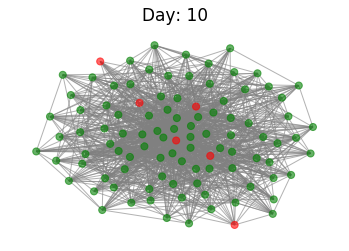

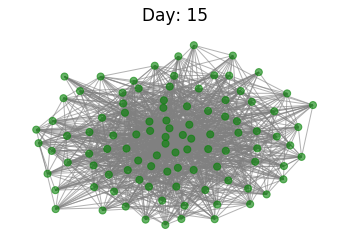

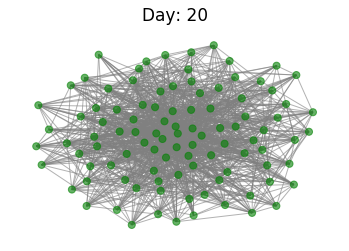

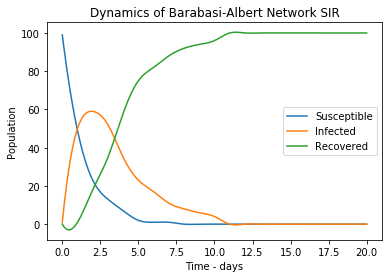

In [31]:
N = 100
beta = 2
gamma = 1/3
t_stop = 20
t_new = np.arange(0, t_stop+1)

graph = 'Barabasi-Albert'
g = nx.barabasi_albert_graph(N, 15, seed=7)
print("Barabasi-Albert : ",nx.info(g))

# initially all susceptible
for node in g:   
    g.nodes[node]['state'] = 'S'

random1 = int(np.random.uniform(0,100))

# start infection
g.nodes[random1]['state'] = 'I'

res = Netwrok_graph(g, graph, beta, gamma, t_stop)

count = pd.DataFrame(res,columns=['S', 'I', 'R'])

time = np.linspace(t_new.min(), t_new.max(), 150)

cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,0])
new_results0 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,1])
new_results1 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,2])
new_results2 = cubic_interpolation_model(time)

plt.plot(time, new_results0, label = 'Susceptible')
plt.plot(time, new_results1, label = 'Infected')
plt.plot(time, new_results2, label = 'Recovered')

plt.title('Dynamics of Barabasi-Albert Network SIR')
plt.xlabel('Time - days')
plt.ylabel('Population')
plt.legend(labels=['Susceptible','Infected','Recovered'],loc="right")
plt.show()

Watts-Strogatz / small world network

Watts-Strogatz :  Graph with 100 nodes and 300 edges


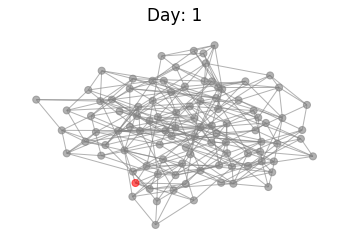

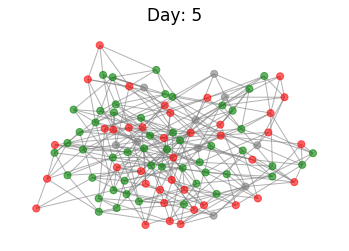

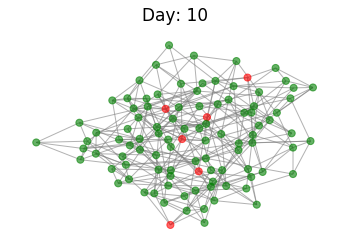

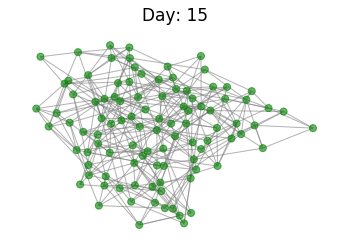

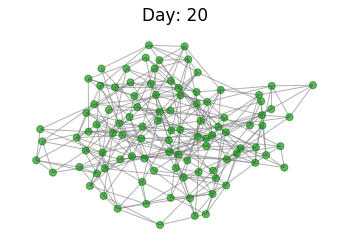

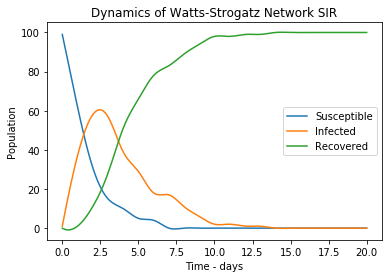

In [32]:
N = 100
beta = 2
gamma = 1/3
t_stop = 20
t_new = np.arange(0, t_stop+1)

graph = 'Watts-Strogatz'
g = nx.watts_strogatz_graph(N, 6, 0.4, seed=7)
print("Watts-Strogatz : ",nx.info(g))

# initially all susceptible
for node in g:   
    g.nodes[node]['state'] = 'S'

random1 = int(np.random.uniform(0,100))

# start infection
g.nodes[random1]['state'] = 'I'

res = Netwrok_graph(g, graph, beta, gamma, t_stop)

count = pd.DataFrame(res,columns=['S', 'I', 'R'])

time = np.linspace(t_new.min(), t_new.max(), 150)

cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,0])
new_results0 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,1])
new_results1 = cubic_interpolation_model(time)
cubic_interpolation_model = make_interp_spline(t_new, count.iloc[:,2])
new_results2 = cubic_interpolation_model(time)

plt.plot(time, new_results0, label = 'Susceptible')
plt.plot(time, new_results1, label = 'Infected')
plt.plot(time, new_results2, label = 'Recovered')

plt.title('Dynamics of Watts-Strogatz Network SIR')
plt.xlabel('Time - days')
plt.ylabel('Population')
plt.legend(labels=['Susceptible','Infected','Recovered'],loc="right")
plt.show()

#### Varying initialisation - changing I

In [33]:
N = 100
beta = 0.9
gamma = 0.2
t_stop = 20

times = 50
t_new = np.arange(0, t_stop+1)

Text(0.5, 1.0, 'Erdos-Reyni dynamics')

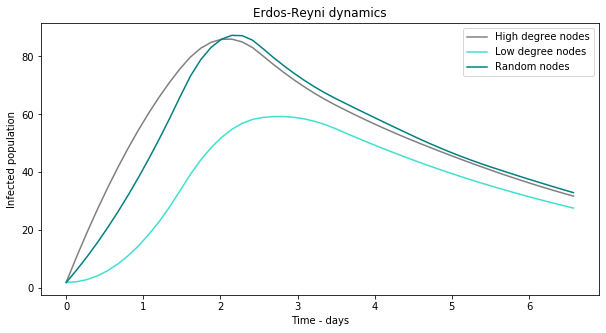

In [34]:
# Erdos-Reyni

# start with random infected
results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05)

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results1 = cubic_interpolation_model(time)


# start with highest degree node infected
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    g = nx.erdos_renyi_graph(N, 0.05)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results2 = cubic_interpolation_model(time)


# start with lowest degree node infected
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    g = nx.erdos_renyi_graph(N, 0.05)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results3=cubic_interpolation_model(time)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time[:50], new_results2[:50], color = 'gray', label = 'High degree nodes')
ax.plot(time[:50], new_results3[:50], color = 'turquoise', label = 'Low degree nodes')
ax.plot(time[:50], new_results1[:50], color = 'teal', label = 'Random nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('Erdos-Reyni dynamics')

Text(0.5, 1.0, 'Barabasi-Albert dynamics')

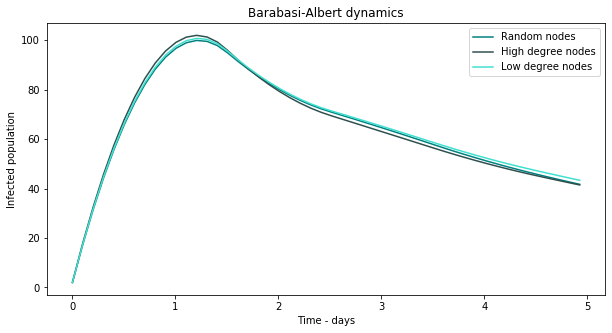

In [35]:
# Barabasi - Albert

# start with random infected
results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 15, seed = seed_random1)

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results1 = cubic_interpolation_model(time)

# start with highest degree node infected
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 15, seed = seed_random)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results2 = cubic_interpolation_model(time)


# start with lowest degree node infected
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 15, seed = seed_random)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results3 = cubic_interpolation_model(time)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time[:50], new_results1[:50], color = 'teal', label = 'Random nodes')
ax.plot(time[:50], new_results2[:50], color = 'darkslategray', label = 'High degree nodes')
ax.plot(time[:50], new_results3[:50], color = 'turquoise', label = 'Low degree nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('Barabasi-Albert dynamics')

Text(0.5, 1.0, 'Watts-Strogatz dynamics')

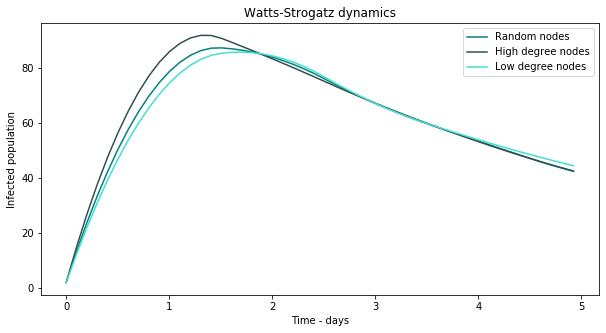

In [36]:
# Strogats-Wattz

# start with random infected
results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results1 = cubic_interpolation_model(time)


# start with highest degree node infected
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results2 = cubic_interpolation_model(time)


# start with lowest degree node infected
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results3 = cubic_interpolation_model(time)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time[:50], new_results1[:50], color = 'teal', label = 'Random nodes')
ax.plot(time[:50], new_results2[:50], color = 'darkslategray', label = 'High degree nodes')
ax.plot(time[:50], new_results3[:50], color = 'turquoise', label = 'Low degree nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('Watts-Strogatz dynamics')

#### Vaccine strategy

In [37]:
N = 100
beta = 0.1
gamma = 0.04

t_stop = 40
times = 50
t_new = np.arange(0, t_stop+1)

Text(0.5, 1.0, '(a) Erdos-Reyni dynamics - Vaccination')

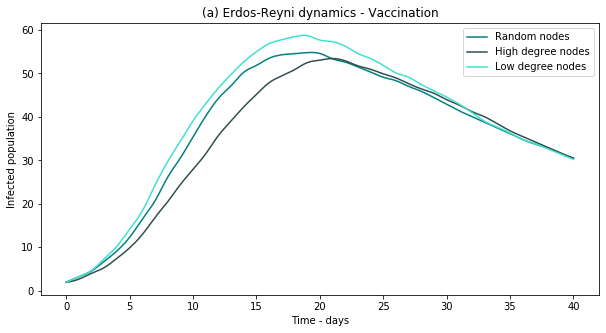

In [38]:
# Erdos-Renyi model vaccinations

results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1)

    # Set random infections and vaccinations
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'
    
    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results1 = cubic_interpolation_model(time)


# Vaccinate four highest degree nodes
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    # Set the four node with highestdegree as vaccinated
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results2 = cubic_interpolation_model(time)



# Vaccinate four lowest degree nodes
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the four node with lowest degree as vaccinated
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 200)
new_results3 = cubic_interpolation_model(time)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time, new_results1, color = 'teal', label = 'Random nodes')
ax.plot(time, new_results2, color = 'darkslategray', label = 'High degree nodes')
ax.plot(time, new_results3, color = 'turquoise', label = 'Low degree nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('(a) Erdos-Reyni dynamics - Vaccination')

Text(0.5, 1.0, '(b) Barabasi-Albert dynamics - Vaccination')

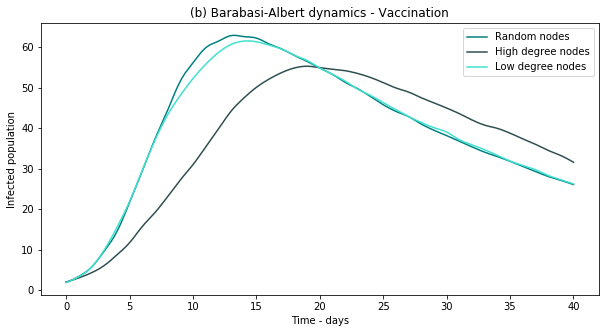

In [39]:
# Barabasi-Albert model vaccinations

results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1)

    # Set random infections and vaccinations
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'
    
    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results1 = cubic_interpolation_model(time)


# Vaccinate four highest degree nodes
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    # Set the four node with highest degree as vaccinated
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results2 = cubic_interpolation_model(time)



# Vaccinate four lowest degree nodes
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the four node with lowest degree as vaccinated
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results3 = cubic_interpolation_model(time)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time, new_results1, color = 'teal', label = 'Random nodes')
ax.plot(time, new_results2, color = 'darkslategray', label = 'High degree nodes')
ax.plot(time, new_results3, color = 'turquoise', label = 'Low degree nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('(b) Barabasi-Albert dynamics - Vaccination')

Text(0.5, 1.0, '(c) Watts-Strogatz dynamics - Vaccination')

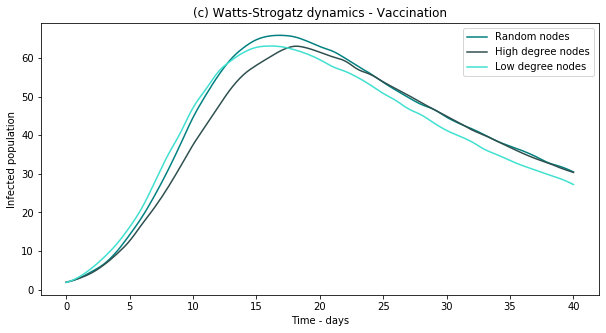

In [40]:
# Watts-Strogatz model vaccinations

results1 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    # Set random infections and vaccinations
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'
    
    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times

cubic_interpolation_model = interp1d(t_new, results1.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results1 = cubic_interpolation_model(time)


# Vaccinate four highest degree nodes
results2 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)

    # Set the four node with highest degree as vaccinated
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times

cubic_interpolation_model = interp1d(t_new, results2.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results2 = cubic_interpolation_model(time)



# Vaccinate four lowest degree nodes
results3 = pd.DataFrame(np.zeros([t_stop + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4)

    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the four node with lowest degree as vaccinated
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for all nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    results = dynamics(g, beta, gamma, t_stop)
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times

cubic_interpolation_model = interp1d(t_new, results3.iloc[:,1], kind = "quadratic")

time = np.linspace(t_new.min(), t_new.max(), 150)
new_results3 = cubic_interpolation_model(time)


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(time, new_results1, color = 'teal', label = 'Random nodes')
ax.plot(time, new_results2, color = 'darkslategray', label = 'High degree nodes')
ax.plot(time, new_results3, color = 'turquoise', label = 'Low degree nodes')
ax.set_xlabel('Time - days')
ax.set_ylabel('Infected population')
ax.legend()
ax.set_title('(c) Watts-Strogatz dynamics - Vaccination')